# Label Frames & Train Frame Classifier

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook allows you to label the individual frames in a video from which a classifier in the sklearn library can be trained.

Notebook exports: labelled frames in a csv file and a trained model in a joblib file.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Labeller](#1.-Detect-Pose-&-Label)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)

# 0. Import Libraries & Setup

In [1]:
folder_name = 'bicep-curl-videos'
output_input_csv_filename = 'bicep-curl-labelled-frames.csv'

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import pickle
from joblib import dump, load

import cv2
import mediapipe as mp

import os

In [3]:
all_landmarks = [] # List of dictionaries storing all the landmarks

def label_landmarks(landmarks, label):
    unboxed_landmarks = {}
    unboxed_landmarks['label'] = label # Label of the keypoint's coordinates
    
    # Store all the keypoint's x0,y0,z0...z32 coordinates in dictionary
    for i in range(33):
        unboxed_landmarks['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmarks['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmarks['z' + str(i)] = landmarks.landmark[i].z
        
    all_landmarks.append(unboxed_landmarks)

# 1. Detect Pose & Label

The code below is used to label frames in all the videos in a folder. First we find the training set and set aside the test set in the evaluation.

- Press 'e' to label a frame as having too much elbow movement
- Press 's' to label a frame as having too much shoulder movement
- Press 'g' to label a frame as being good

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

all_videos = []

directory = os.fsencode(folder_name)

for file in os.listdir(directory):
    all_videos.append(os.fsdecode(file))
    
# Filenames of the videos we want to train the frame labeller on
# The test set is in f1-gen-heuristic notebook, same seed is used so same train and test set is created
train_videos, _, _, _ = train_test_split(all_videos, all_videos, test_size=0.33, random_state=42)

exit = False

for filename in train_videos:
    cap = cv2.VideoCapture(folder_name + '/' + filename)
    with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

        while cap.isOpened():
            ret, image = cap.read()

            if ret == False:
                break
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            cv2.rectangle(image, (0,0), (225, 100), (0,0,0), -1)

            k = cv2.waitKey(1)
            # Press 'e' to label frame as elbow
            if k == 101:
                label_landmarks(results.pose_landmarks, 'elbow')
                cv2.putText(image, 'elbow', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

            # Press 's' to label frame as shoulder
            if k == 115:
                label_landmarks(results.pose_landmarks, 'shoulder')
                cv2.putText(image, 'shoulder', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)

            # Press 'g' to label frame as good
            if k == 103:
                label_landmarks(results.pose_landmarks, 'good')
                cv2.putText(image, 'good', (60,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
                
            # Press ESC to quit
            if k == 27:
                exit = True
                break

            cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
            cv2.imshow("output", image)

        cap.release()
        cv2.destroyAllWindows()
        if exit == True:
            break

In [5]:
# Save the data in a csv
landmarks_df = pd.DataFrame(all_landmarks)
landmarks_df.to_csv(output_input_csv_filename, index=False)

In [45]:
# Read the data from a csv
landmarks_df = pd.read_csv(output_input_csv_filename)
landmarks_df

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,elbow,0.443093,0.161381,-0.101420,0.450379,0.144473,-0.165286,0.454412,0.143811,-0.165362,...,-0.016946,0.583670,0.760894,0.573409,0.436530,0.808394,-0.174437,0.463945,0.765809,0.525320
1,elbow,0.447388,0.180204,-0.120142,0.442015,0.163513,-0.182616,0.445655,0.161362,-0.182662,...,-0.008184,0.583494,0.754490,0.536074,0.432123,0.808205,-0.154826,0.463750,0.761782,0.496120
2,elbow,0.460635,0.177298,-0.100945,0.456729,0.160945,-0.164320,0.459875,0.159335,-0.164340,...,-0.000498,0.583771,0.754715,0.480002,0.429977,0.808668,-0.147399,0.463581,0.761515,0.436693
3,elbow,0.462211,0.166524,-0.100571,0.460950,0.148563,-0.163544,0.464577,0.147461,-0.163577,...,0.080868,0.577578,0.756123,0.537807,0.432419,0.806675,-0.067822,0.458218,0.763661,0.482909
4,elbow,0.462060,0.156854,-0.082532,0.466014,0.140115,-0.142117,0.469821,0.139524,-0.142199,...,-0.034920,0.580388,0.759046,0.565462,0.436141,0.803172,-0.208801,0.455701,0.760788,0.522673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,elbow,0.445262,0.195094,-0.060764,0.445062,0.177167,-0.125263,0.448945,0.175737,-0.125293,...,-0.129435,0.615893,0.785729,0.700741,0.466888,0.849227,-0.292871,0.481084,0.792984,0.677866
296,elbow,0.463613,0.198097,-0.132433,0.470118,0.181107,-0.197287,0.475608,0.179858,-0.197218,...,-0.185787,0.607302,0.782388,0.688053,0.465918,0.852424,-0.350524,0.478923,0.793839,0.666587
297,elbow,0.464070,0.198900,-0.053110,0.468875,0.181811,-0.120282,0.473976,0.180304,-0.120272,...,-0.090150,0.609173,0.804751,0.606350,0.466810,0.853727,-0.237127,0.479318,0.798613,0.565754
298,elbow,0.464874,0.199419,-0.043170,0.466426,0.182332,-0.107780,0.470673,0.180684,-0.107811,...,0.024804,0.634873,0.824164,0.454501,0.467835,0.856326,-0.123714,0.485973,0.809859,0.387884


In [46]:
landmarks_df['label'].value_counts()

good        173
elbow        67
shoulder     60
Name: label, dtype: int64

# 2. Train & Evaluate Models

In [47]:
model_scores = [] # Used for comparing different model's scores

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                     'Accuracy': acc, 
                     'Precision': precision, 
                     'Recall': recall,
                     'F1 Score': f1}

    if display_matrix:
        labels= ['elbow', 'shoulder', 'good']
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()
    
    return model_metrics

In [48]:
model_scores = [] # Used for comparing different model's scores

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(201, 99) (201,) (99, 99) (99,)


## Feature Extraction

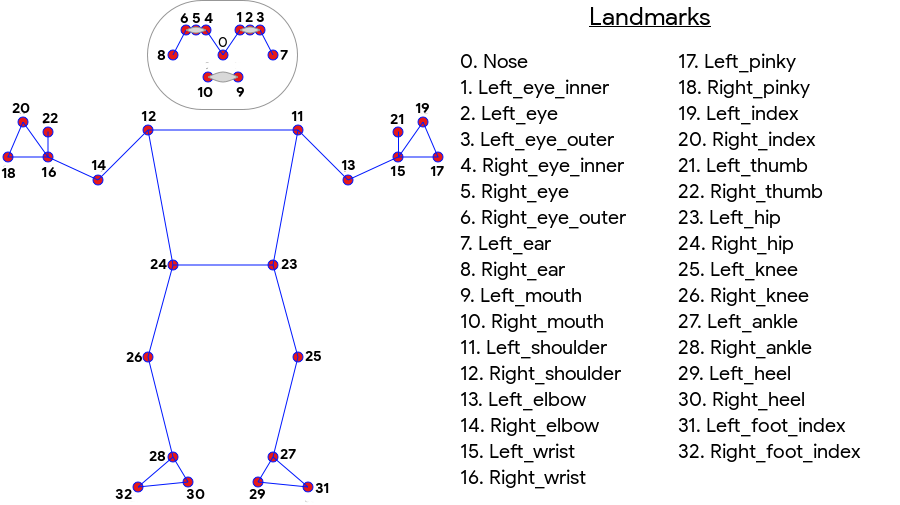

In [49]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [50]:
landmarks_df['hip_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
landmarks_df['elbow_hip_angle'] = landmarks_df.apply(lambda row: get_angle(row, 13, 11, 23), axis=1)
landmarks_df['bicep_angle'] = landmarks_df.apply(lambda row: get_angle(row, 11, 13, 15), axis=1)

In [51]:
landmarks_df.head()

,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z30,x31,y31,z31,x32,y32,z32,hip_angle,elbow_hip_angle,bicep_angle
0,elbow,0.443093,0.161381,-0.101420,0.450379,0.144473,-0.165286,0.454412,0.143811,-0.165362,...,0.573409,0.436530,0.808394,-0.174437,0.463945,0.765809,0.525320,176.097048,74.941286,83.789244
1,elbow,0.447388,0.180204,-0.120142,0.442015,0.163513,-0.182616,0.445655,0.161362,-0.182662,...,0.536074,0.432123,0.808205,-0.154826,0.463750,0.761782,0.496120,176.544631,74.806848,53.676714
2,elbow,0.460635,0.177298,-0.100945,0.456729,0.160945,-0.164320,0.459875,0.159335,-0.164340,...,0.480002,0.429977,0.808668,-0.147399,0.463581,0.761515,0.436693,178.003719,72.561587,56.491211
3,elbow,0.462211,0.166524,-0.100571,0.460950,0.148563,-0.163544,0.464577,0.147461,-0.163577,...,0.537807,0.432419,0.806675,-0.067822,0.458218,0.763661,0.482909,178.130870,62.485561,74.370604
4,elbow,0.462060,0.156854,-0.082532,0.466014,0.140115,-0.142117,0.469821,0.139524,-0.142199,...,0.565462,0.436141,0.803172,-0.208801,0.455701,0.760788,0.522673,175.159576,49.874011,97.356494


In [52]:
landmarks_df = landmarks_df.filter(['bicep_angle', 'elbow_hip_angle', 'hip_angle', 'label'])

# Setup the testing and training sets
X = landmarks_df.drop('label', axis=1)
y = landmarks_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(201, 3) (201,) (99, 3) (99,)


In [53]:
X_train

,bicep_angle,elbow_hip_angle,hip_angle
67,76.809597,69.255183,166.614503
228,144.410156,3.957001,162.840716
69,83.920028,7.827601,165.830109
31,34.925415,88.383623,173.292886
183,32.139254,20.610983,115.004499
...,...,...,...
188,67.513177,10.518128,171.432448
71,103.893726,9.839522,168.340991
106,46.350982,25.776697,133.418092
270,82.093922,11.800466,163.368113


Trying to extract the angles seems to make the LinearSVC model perform worse.

## Models

### Linear SVC

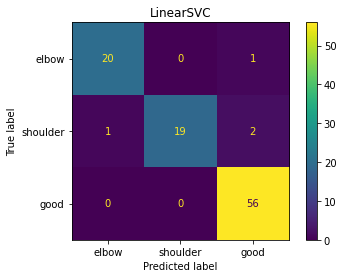

{'Classifier': 'LinearSVC', 'Accuracy': 0.9595959595959596, 'Precision': 0.9671778315846112, 'Recall': 0.9386724386724387, 'F1 Score': 0.9595959595959596}


In [54]:
svc_model = make_pipeline(StandardScaler(), LinearSVC(random_state=1, tol=1e-5)).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

scores = evaluate_model('LinearSVC', y_pred, True)
model_scores.append(scores)
print(scores)

In [55]:
dump(svc_model, 'svc-bicep-curl-mistakes.joblib') # Export model

['svc-bicep-curl-mistakes.joblib']

### K-Nearest Neighbours

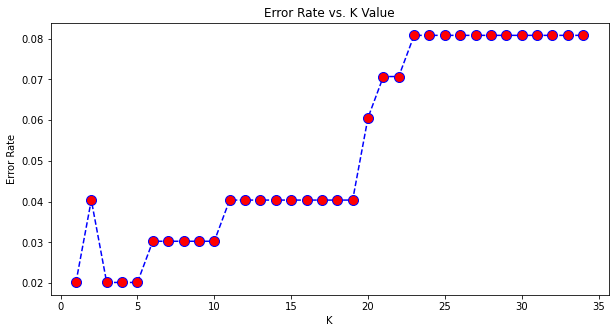

In [56]:
# Find K value with lowest error
error_rate = []
for i in range(1,35):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,5))
plt.plot(range(1,35),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

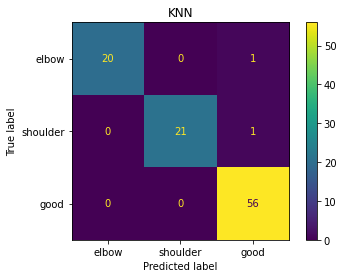

{'Classifier': 'KNN', 'Accuracy': 0.9797979797979798, 'Precision': 0.9885057471264368, 'Recall': 0.9689754689754689, 'F1 Score': 0.9797979797979798}


In [57]:
knc_model = KNeighborsClassifier(1).fit(X_train, y_train)
y_pred = knc_model.predict(X_test)
scores = evaluate_model('KNN', y_pred, True)
model_scores.append(scores)
print(scores)

In [58]:
dump(knc_model, 'knc-bicep-curl-mistakes.joblib') # Export model

['knc-bicep-curl-mistakes.joblib']

### Neural Network

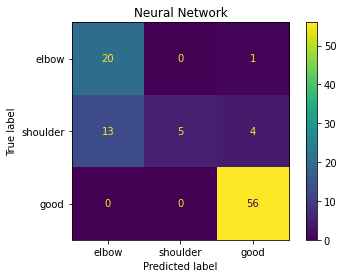

{'Classifier': 'Neural Network', 'Accuracy': 0.8181818181818182, 'Precision': 0.841364464315284, 'Recall': 0.7265512265512265, 'F1 Score': 0.8181818181818182}


In [59]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(activation='relu',
                        learning_rate='adaptive',
                        hidden_layer_sizes=(100),
                        learning_rate_init=0.01,
                        random_state=1)

mlp_model = mlp_clf.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)
scores = evaluate_model('Neural Network', y_pred, True)
model_scores.append(scores)
print(scores)

In [60]:
dump(mlp_model, 'mlp-bicep-curl-mistakes.joblib') # Export model

['mlp-bicep-curl-mistakes.joblib']

### Naive Bayes

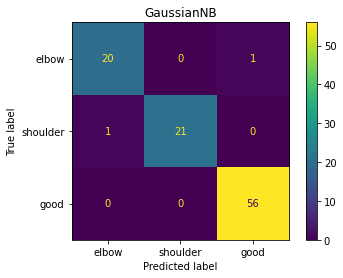

{'Classifier': 'GaussianNB', 'Accuracy': 0.9797979797979798, 'Precision': 0.9782790309106097, 'Recall': 0.9689754689754689, 'F1 Score': 0.9797979797979798}


<Figure size 432x288 with 0 Axes>

In [61]:
gnb_model = GaussianNB()
y_pred = gnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('GaussianNB', y_pred, True)

model_scores.append(scores)
print(scores)

In [62]:
dump(gnb_model, 'gnb-bicep-curl-mistakes.joblib') # Export model

['gnb-bicep-curl-mistakes.joblib']

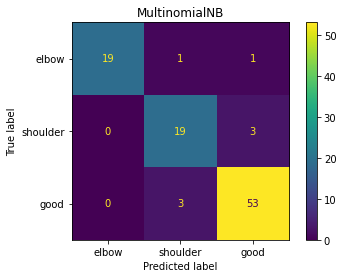

{'Classifier': 'MultinomialNB', 'Accuracy': 0.9191919191919192, 'Precision': 0.9186371726417493, 'Recall': 0.90494227994228, 'F1 Score': 0.9191919191919192}


In [63]:
mnb_model = MultinomialNB()
y_pred = mnb_model.fit(X_train, y_train).predict(X_test)

scores = evaluate_model('MultinomialNB', y_pred, True)
model_scores.append(scores)
print(scores)

In [64]:
eval_scores = pd.DataFrame(model_scores)
eval_scores = eval_scores.sort_values(by = ['F1 Score'], ascending = False)
eval_scores

,Classifier,Accuracy,Precision,Recall,F1 Score
1,KNN,0.979798,0.988506,0.968975,0.979798
3,GaussianNB,0.979798,0.978279,0.968975,0.979798
0,LinearSVC,0.959596,0.967178,0.938672,0.959596
4,MultinomialNB,0.919192,0.918637,0.904942,0.919192
2,Neural Network,0.818182,0.841364,0.726551,0.818182


Now lets see how the top classifiers perform on all the testing set of videos. See f1-gen-frame notebook for the results.